# DecGene code notebook
Latest update: January 26, 2023
Citation: 

This notebook runs the analysis and recreates the primary inputs for the figures in the 2023 DecGene paper. 


### Notes:
* Download input data: https://ucsf.box.com/s/dgyrfc9vgtwz05dkbizqng3i0x7zhsz0
* 

In [1]:
# import libraries
from knn_impute import kNN_imputation
import matplotlib.pyplot as plt
from morans_index import runManyMoranI
import networkx as nx
import numpy as np
import os
from other_functions import correlation_map_with_CCF, geneReconstructionAcccuracy, \
    show_graph_with_labels, filter_genes, weighted_correlation
import pandas as pd
from pca_with_missing_values import pca_with_missing_values
import pickle
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.optimize import nnls
import seaborn as sns
import sklearn.preprocessing
from sklearn_nmf import sklearn_nmf
from stability import findcorrelation, HungarianError, amariMaxError, instability

## Figure 1: The architecture of the DecGene framework and its application in revealing PPs in spatial gene expression datasets.
**A.** The computational framework for DecGene. **B.** Stability analysis for DecGene PPs and PCA PPs across 100 runs for each K value, from 8 to 30 for ABA dataset, using Hungarian matching method. The ABA dataset contains 4,345 3D in situ hybridization (ISH) images at 200 µm3 resolution of the adult mouse brain. Error bars show the standard deviation. **C.** 11 PPs generated by DecGene from the ABA dataset projected in 3D and coronal views. **D.** Boxplots of Moran’s Index for DecGene vs. PCA PPs across 220 bootstrapped simulations (p-value<0.001). Data from each individual point is shown in a vertical column to the right of the boxplot. **E.** Pearson correlation coefficients of DecGene and PCA gene reconstructions vs. the original ABA data. Each dot represents the correlation coefficient DecGene and PCA reconstructions of one of the 4,345 genes versus the original ABA gene-by-gene data. F. Number of PPs represented by each DecGene gene reconstruction of the 4,345 ABA genes. 

### KNN imputation of missing values

In [2]:
# """KNN imputation"""
# # comment out if to load already-imputed data

# #load original input data
# tmp = np.load('../data/mouse_brain_ISH_float32.npz',allow_pickle=True)
# data = tmp['data']
# sections = tmp['sections'].tolist()
# original_shape = data.shape
# original_shape

# # preprocess find the high missing rate region
# all_missed = (np.mean(data < 0, axis=0) >= .95)
# selected = np.logical_not(all_missed)[np.newaxis, :, :, :]

# # fit_model
# knn_model = kNN_imputation(n_neighbors=6, weights='distance')
# imputed = knn_model.fit_transform(data, selected[0], inplace=True)

# # save data
# np.savez("../data/imputed_data_kNN_neighbor_6_weights_distance_2023_01_20.npz",
#          imputed=imputed, selected=selected)

### load imputed data and other data

In [3]:
# load imputed data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

#load reference atlas from Allen Institute for Brain Science, CCF
areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('../data/mouse_coarse_df')

### preprocess

In [4]:
# compute the support
support = np.sum(areas_atlas, 0) > 0

# get the data within the reference atlas
filtered_data = data[:,:-1,:-1,:-1][:, support]
filtered_data.shape

(4345, 55954)

### run NMF model to generate 11 PPs
This is to illustrate how the model is run. Later, we run stability analysis on a variety of values for the number of PPs (K) to determine that 11 is the most stable congfiguration.

In [6]:
###################################
# Create nmf model with 11 PPs, coeffs
###################################

nmf = sklearn_nmf(n_components=11, l1_ratio=1, alpha = 0, random_state=1)
nmf.fit(np.maximum(filtered_data,0)) # fit model

# Create PPs and coeffs
PPs = nmf.components_
coeffs = nmf.transform(np.maximum(filtered_data,0))

# preprocess unmask
PPs_3d = np.zeros((len(PPs), 66, 40, 57))
PPs_3d[:,support] = PPs * (PPs > 0.05)
print(PPs_3d.shape, PPs.shape, coeffs.shape)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


(11, 66, 40, 57) (11, 55954) (4345, 11)


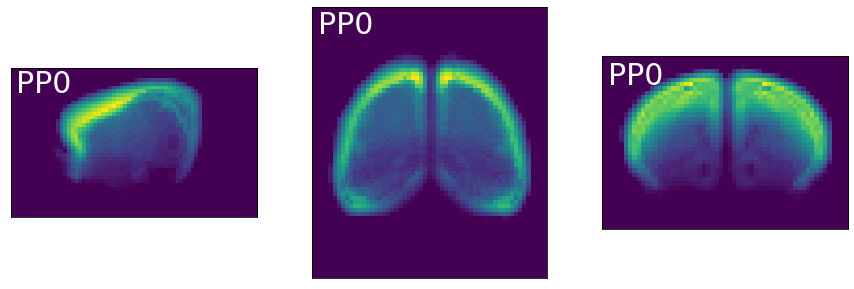

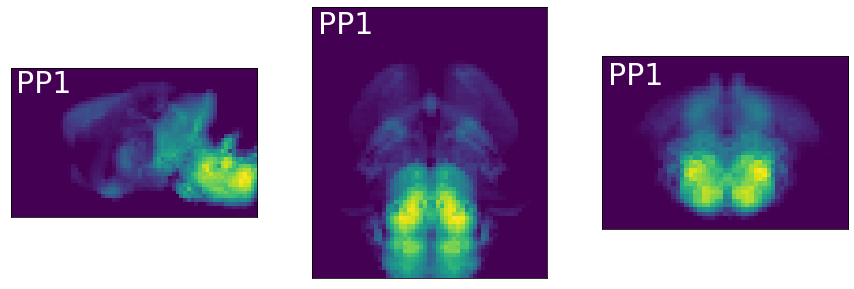

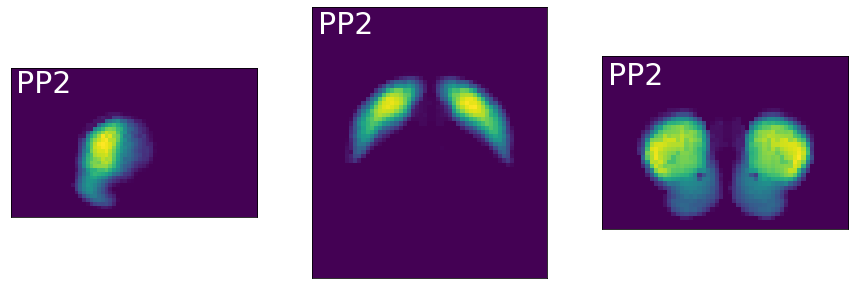

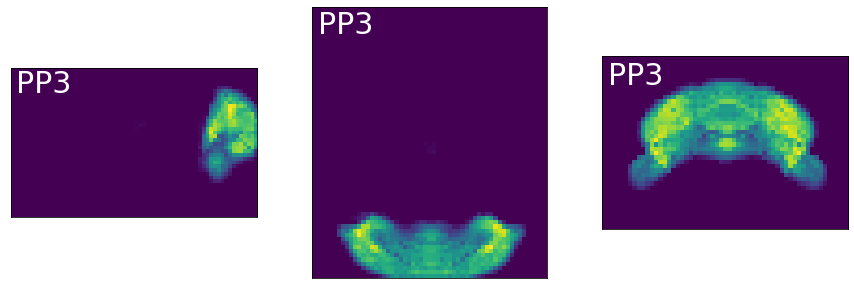

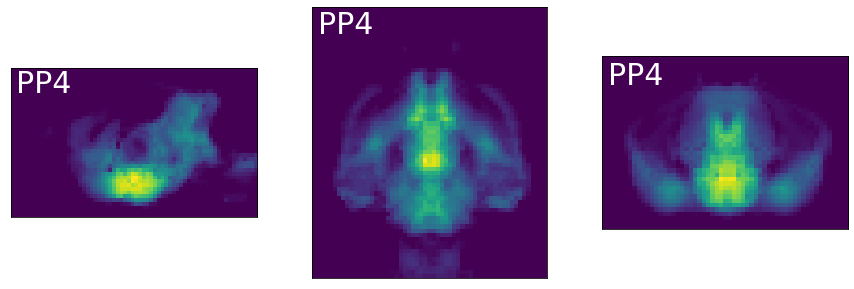

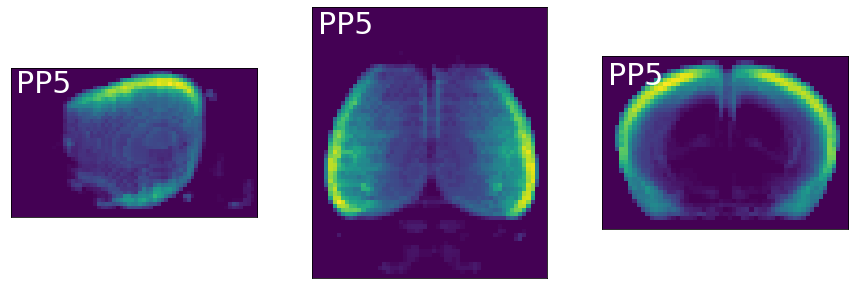

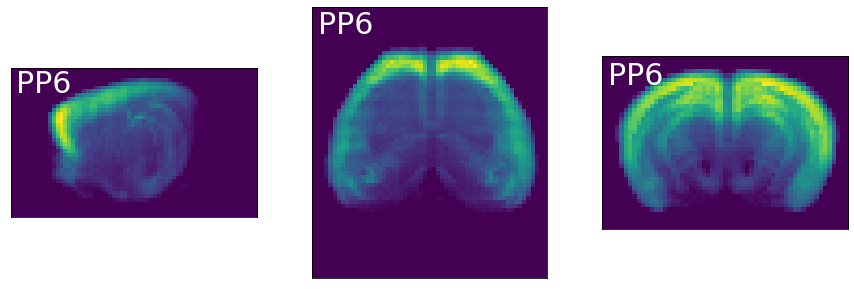

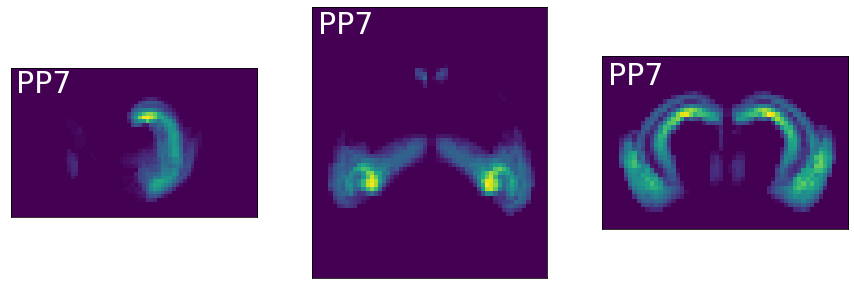

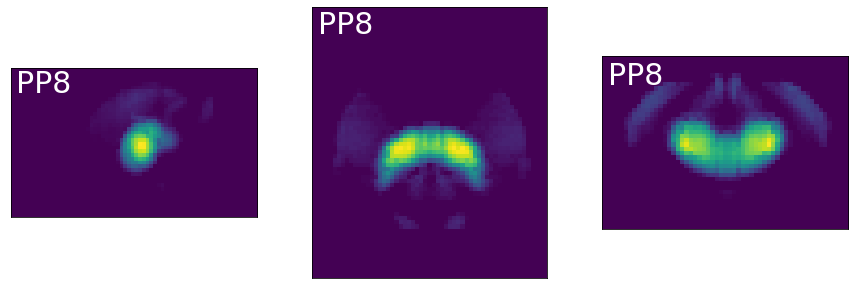

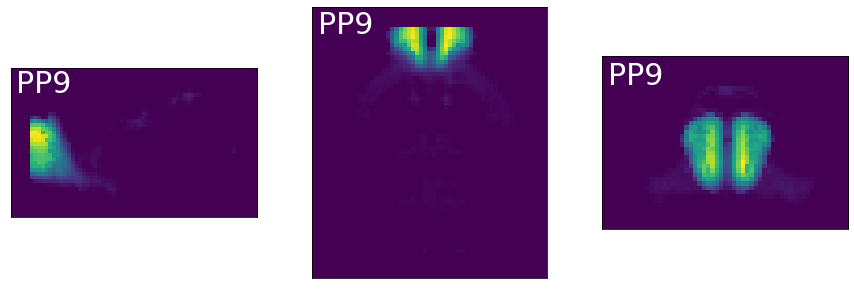

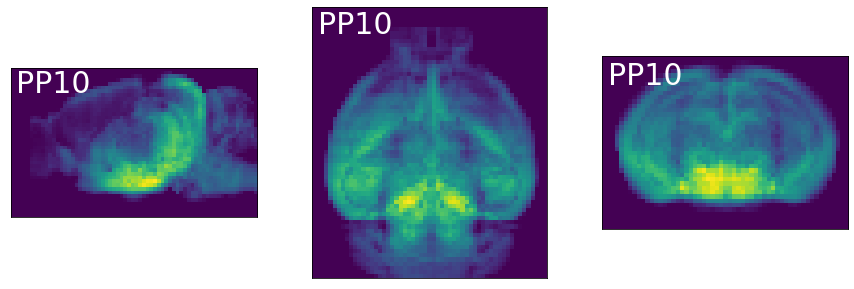

In [7]:
# visualize the PPs
for i in range(11):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(PPs_3d[i, :, :, :], 2).T)
    b.imshow(np.mean(PPs_3d[i, :, :, :], 1))
    c.imshow(np.mean(PPs_3d[i, :, :, :], 0))
    a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)

### histogram of gene reconstruction accuracy for DecGene vs. PCA

Calculation:
1. For each DecGene and PCA,
2. For each of the ~4350 genes,
3. Multiply the coeff for that gene x PP dictionary (the reconstructed gene),
4. Calculate Pearson correlation coeff of that reconstructed gene vs. the actual gene data. (reconstruction accuracy by gene)
5. Store each Pearson correlation coeff in a list.

Output: Two lists of ~4,350 correlation coeffs (gene reconstruction accuracy), one for DecGene, one for PCA

**Fig. 1F** in manuscript

In [9]:
# Run reconstruction function for for stanNMF / DecGene
gene_rec_accuracy_DecGene = geneReconstructionAcccuracy(_PPs=PPs, _coeffs=coeffs,
                                                       _filtered_data=filtered_data)

In [10]:
# Run reconstruction function for PCA

# load PCA model
tmp = np.load('../output/PCA_final_11_PPs.npz')
PPs_PCA = tmp['PPs']
coeffs_PCA = tmp['coeffs']

# run function
gene_rec_accuracy_PCA = geneReconstructionAcccuracy(_PPs=PPs_PCA, _coeffs=coeffs_PCA, _filtered_data=filtered_data)

In [11]:
# Comparing mean accuracy and standard deviation
print("DecGene accuracy & std:",
      round(np.mean(gene_rec_accuracy_DecGene),3),
      ", std:",
      round(np.std(gene_rec_accuracy_DecGene),3))
print("PCA accuracy & std:",
      round(np.mean(gene_rec_accuracy_PCA),3),
      ", std:",
      round(np.std(gene_rec_accuracy_PCA),3))

DecGene accuracy & std: 0.615 , std: 0.217
PCA accuracy & std: 0.371 , std: 0.369


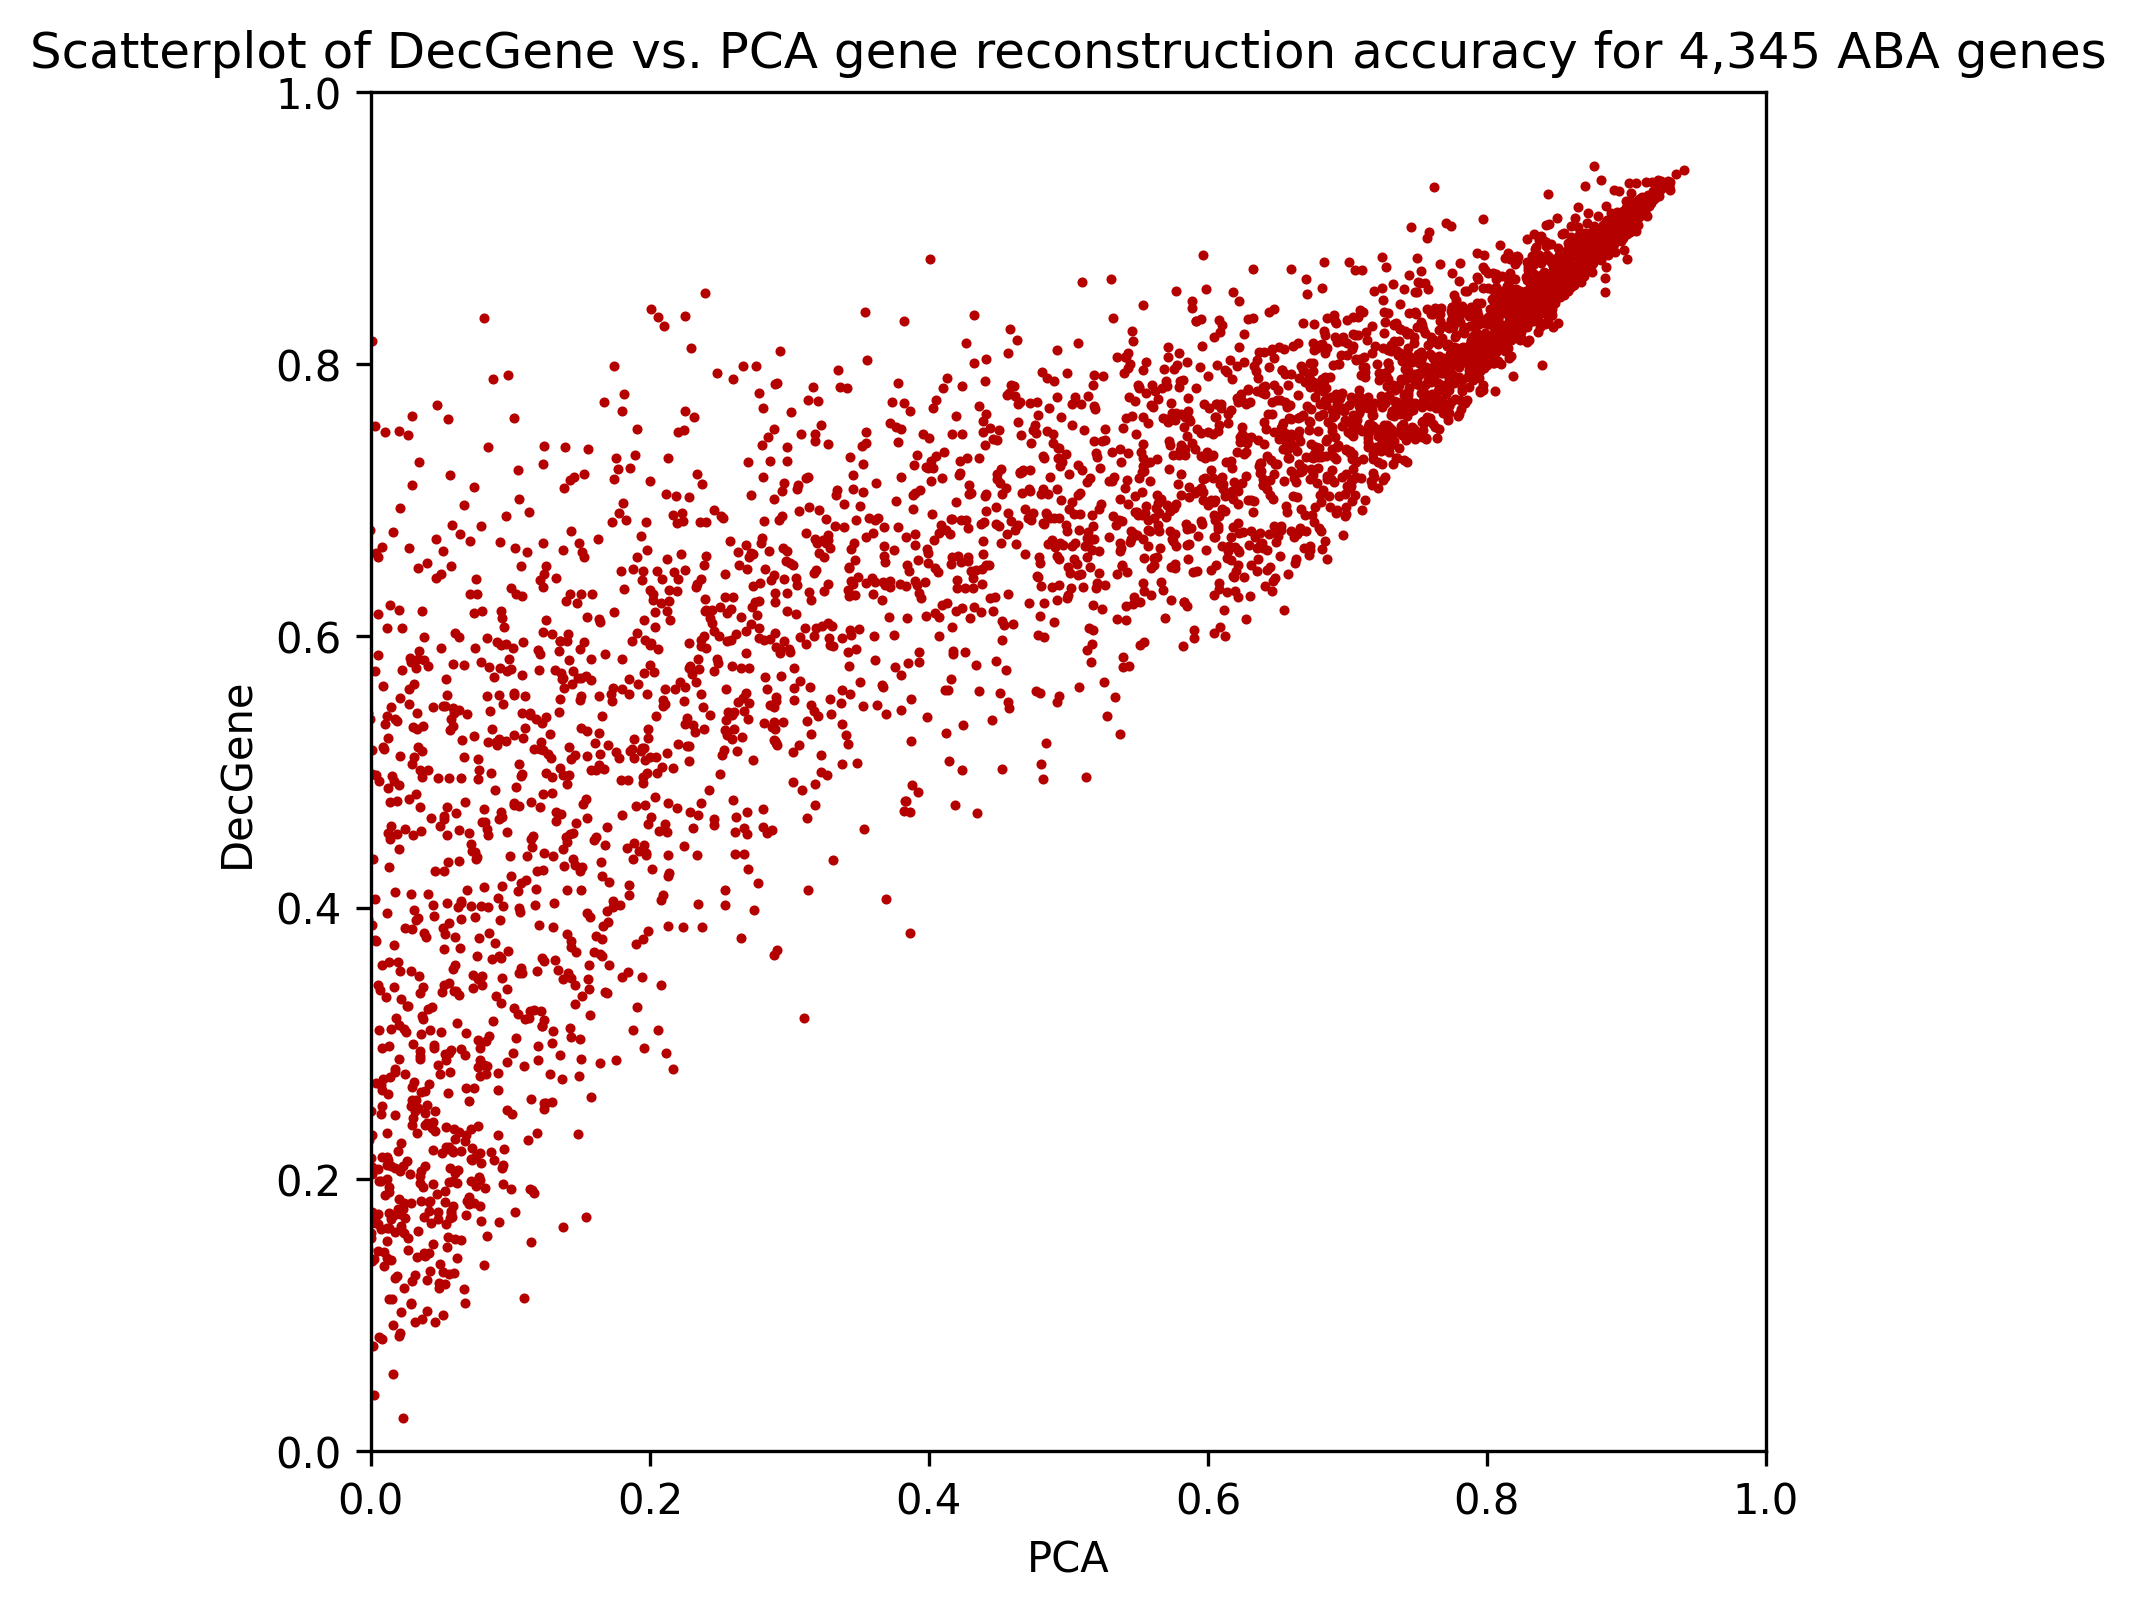

In [12]:
# Plot DecGene vs. PCA gene reconstruction correlations
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(gene_rec_accuracy_PCA, gene_rec_accuracy_DecGene, s=2,alpha=1, color='#B50000')
plt.title('Scatterplot of DecGene vs. PCA gene reconstruction accuracy for 4,345 ABA genes')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('PCA')
plt.ylabel('DecGene')
plt.savefig("../figures/gene_reconstruction.png", dpi=300, transparent=True)
plt.show()

### stability analysis of DecGene vs. PCA

Source: S. Wu, A. Joseph, A. S. Hammonds, S. E. Celniker, B. Yu, and E. Frise, “Stability-driven nonnegative matrix factorization to interpret spatial gene expression and build local gene networks,” Proc. Natl. Acad. Sci., vol. 113, no. 16, Art. no. 15, 2016.

**Fig. 1B** in manuscript

In [13]:
# RUN SIMULATIONS OF EACH K VALUE
# Note: this takes roughly an hour for every 100 replicates on a 2021 MacBook Pro M1.
# For K=5 to K=50, this took roughly ~45 hours.

# Set key variables
K1=5        # sets lower bound (including itself) of PPs
K2=50       # sets upper bound (including itself) of PPs 
B=100        # sets number of replicates
start=0        # start number for naming replicates
folder_path = '../output/instability_runs'

# Set intermediate variables
numPatterns = np.arange(K1, K2+1)

# Run DG and PCA _num_set times to generate _num_set PPs
for k in range(len(numPatterns)):
    K = numPatterns[k]

    # set new directory for K
    path = folder_path + '/K=' + str(K)
    try:
        os.makedirs(path)
    except OSError:
        if not (os.path.isdir(path)):
            raise

    # prep for runs
    print("Working on K = {}...".format(K))
    
    for b in range(B):

        # Bootstrap data and use same bootstrap input for DecGene & PCA
        np.random.seed(b) # set seed based on s
        X = np.maximum(filtered_data,0)
        n_samples = X.shape[0]
        bootstrap_X = X[np.random.choice(
            n_samples,
            n_samples,
            replace=True)]

        # run and save DecGene
        from sklearn_nmf import sklearn_nmf
        nmf = sklearn_nmf(n_components=K, l1_ratio=1, alpha = 0, random_state=1)
        nmf.fit(bootstrap_X) # fit model with bootstrapped data
        PPs_tmp = nmf.components_
        np.savez(path + '/DG_PP_' + str(b+start),PPs_tmp=PPs_tmp)
        
        # run and save PCA
        from pca_with_missing_values import pca_with_missing_values
        pca = pca_with_missing_values(n_components=K)
        pca.fit(bootstrap_X) # fit model
        PPs_tmp = pca.components_
        np.savez(path + '/PCA_PP_' + str(b+start),PPs_tmp=PPs_tmp)

In [14]:
############################################
# Calculate Instability for DecGene and PCA
############################################

# Set key variables
K1=8       # sets lower bound (including itself) of PPs
K2=30       # sets upper bound (including itself) of PPs 
B=100       # sets number of replicates
folder_path = "../output/instability_runs"
name_DG="DG_PP"
name_PCA="PCA_PP"

from scipy.optimize import linear_sum_assignment
import sklearn.preprocessing


# Load data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz', allow_pickle=True)
data = tmp['imputed']
selected = tmp['selected']
del tmp

# Set intermediate variables
numPatterns = np.arange(K1, K2+1)
shape_flat = 55954

# Run instability
print("Run instability for DecGene:")
instability_DG, instability_std_DG, distMat_DG = instability(_folder_path=folder_path,
                                                             _k1=K1,
                                                             _k2=K2,
                                                             _numReplicates=B,
                                                             _n_features=shape_flat,
                                                             _name=name_DG)

# Run instability
print("\nRun instability for PCA:")
instability_PCA, instability_std_PCA, distMat_PCA = instability(_folder_path=folder_path,
                                                             _k1=K1,
                                                             _k2=K2,
                                                             _numReplicates=B,
                                                             _n_features=shape_flat,
                                                             _name=name_PCA)

# save files
# np.savez("../output/instability_calcs.npz",
#          instability_DG=instability_DG,
#          instability_std_DG=instability_std_DG,
#          instability_PCA=instability_PCA,
#          instability_std_PCA=instability_std_PCA)

Run instability for DecGene:
Calculating instability for 8
Calculating instability for 9
Calculating instability for 10
Calculating instability for 11


KeyboardInterrupt: 

In [ ]:
# Plot instability curves for DG and PCA

# generate data
names = list(instability_DG.keys())
values1 = list(instability_DG.values())
values1_std = list(instability_std_DG.values())
values1_std = [item * 2 for item in values1_std] # multiply StdDev by 2
values2 = list(instability_PCA.values())
values2_std = list(instability_std_PCA.values())
values2_std = [item * 2 for item in values2_std] # multiply StdDev by 2

# plot chart with error bars
plt.figure(figsize=(8, 8))
plt.errorbar(range(len(instability_DG)), values1, values1_std, ecolor='#ED1C24', color='#ED1C24',
             capsize=5, linewidth=4, elinewidth=2)
plt.errorbar(range(len(instability_PCA)), values2, values2_std, ecolor='grey', color='grey',
             capsize=5, linewidth=4, elinewidth=2)
plt.xlabel('K (# of PPs)')
plt.ylabel("Instability Index")
plt.title("Instability by stage by # of PPs\n" +str(B) + " simulations per K value")
plt.xticks(range(K2-K1),range(K1,K2))
plt.axis([-2, (K2-K1+1), 0, 0.45])
# plt.legend(['DecGene', 'PCA'])
plt.savefig('../figures/instability.jpg', transparent=False, dpi=100)
plt.show()

### 3D and coronal visualization of PPs
**Fig. 1C** in manuscript

### spatial coherence
Using Moran's I and Geary's C as measures. Uses morans_index.py for functions.

**Fig. 1D** in manuscript


In [ ]:
## Load existing data

# import data
MoranI = np.load('../output/manyruns_DG_PCA_2022_10_17.npz')
I_manyRuns_DG = MoranI["I_manyRuns_DG"]
I_manyRuns_PCA = MoranI["I_manyRuns_PCA"]

# # Load DecGene PPs
# tmp = np.load('DecGene_final_11_PPs.npz')
# PPs_DG = tmp['PPs_3d']

# # Load PCA PPs
# tmp = np.load('PCA_final_11_PPs.npz')
# PPs_PCA = tmp['PPs_3d']

### DecGene
# I_DG = MoranIforPPs(PPs_DG,_removeEmptyLayers=False)
print("---\nDecGene:", np.mean(I_manyRuns_DG), np.median(I_manyRuns_DG), np.std(I_manyRuns_DG))

### PCA
# I_PCA = MoranIforPPs(PPs_PCA,_removeEmptyLayers=False)
print("---\nPCA:", np.mean(I_manyRuns_PCA), np.median(I_manyRuns_PCA),np.std(I_manyRuns_PCA))

### Two-tailed test
#print(stats.ttest_ind(I_manyRuns_DG, I_manyRuns_PCA))


In [ ]:
# ## Calculate Moran's I across n runs per PP

# from morans_index import MoranIforPPs

# # set number of runs per PP
# n_runs = 20

# # set downsampling amount (delete every _n values across all axes)
# _downsample=2

# # Load DecGene PPs
# tmp = np.load('../output/DecGene_final_11_PPs.npz')
# PPs_DG = tmp['PPs_3d']

# # Load PCA PPs
# tmp = np.load('../output/PCA_final_11_PPs.npz')
# PPs_PCA = tmp['PPs_3d']

# # Load brain mask
# areas_atlas = np.load('../data/mouse_coarse_structure_atlas.npy')
# mask = np.max(areas_atlas, axis=0)

# PPs_3d_tmp=PPs_PCA
# _mask=mask

# ## DecGene
# I_manyRuns_DG = runManyMoranI(_n=n_runs,
#                               _DecGeneOrPCA="DecGene",
#                               _PPs=PPs_DG,
#                               _mask=mask,
#                               _downsample=_downsample)
# print("---\nDecGene:", np.mean(I_manyRuns_DG), np.median(I_manyRuns_DG), np.std(I_manyRuns_DG))

# ## PCA
# I_manyRuns_PCA = runManyMoranI(_n=n_runs,
#                               _DecGeneOrPCA="PCA",
#                               _PPs=PPs_PCA,
#                               _mask=mask,
#                               _downsample=_downsample)
# print("---\nPCA:", np.mean(I_manyRuns_PCA), np.median(I_manyRuns_PCA), np.std(I_manyRuns_PCA))

In [ ]:
# #save
# np.savez('../output/manyruns_DG_PCA_2022_10_17.npz',I_manyRuns_DG=I_manyRuns_DG,I_manyRuns_PCA=I_manyRuns_PCA)

In [ ]:
# # Create boxplots for DecGene vs. PCA

# # flatten data so all 20*11 samples are included
# I_DG = np.reshape(I_manyRuns_DG,(I_manyRuns_DG.shape[0]*I_manyRuns_DG.shape[1]))
# I_PCA = np.reshape(I_manyRuns_PCA,(I_manyRuns_PCA.shape[0]*I_manyRuns_PCA.shape[1]))

# ### Two-tailed test
# print(stats.ttest_ind(I_DG, I_PCA))

# #get data
# df1 = pd.DataFrame(data=I_DG,columns=["DecGene"])
# df2 = pd.DataFrame(data=I_PCA,columns=["PCA"])
# df1 = pd.concat([df1, df2],axis=1)
# my_pal = {"DecGene": '#ED1C24', "PCA": '#939598'}

# # figure
# sns.set(rc={'figure.figsize':(14,12)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})
# box1 = sns.boxplot(data=df1,width=0.5, palette=my_pal, linewidth=6,
#                    flierprops={"markerfacecolor":'white',
#                                "markersize":.1, 
#                                "markeredgecolor":'white'})
# # box1.set_ylim(0, 1)
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
#     line.set(linewidth=6)

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransIboxPlot.png",dpi=300)

In [ ]:
# # create jittered scatterplot to combine with boxplots for figure 1D

# #x-axis
# x_DG = np.random.randint(100, size=I_DG.shape[0]) # to jitter the data points
# x_PCA = np.random.randint(100, size=I_PCA.shape[0]) # to jitter the data points

# #plot DG
# plt.scatter(x_DG,I_DG, color='#ED1C24')
# plt.xlim(-700,800)
# plt.ylim(0,1)
# plt.savefig("../figures/Moran_scatter_DG.png",dpi=300)
# plt.clf()

# #plot PCA
# plt.scatter(x_PCA,I_PCA, color='grey')
# plt.xlim(-700,800)
# plt.ylim(0,1)
# plt.savefig("../figures/Moran_scatter_PCA.png",dpi=300)

In [ ]:
# # Create boxplots for DG and PCA, in order of DG PPs

# # # import data
# # MoranI_DG = np.load('MoranI_20_runs_DG.npz')
# # I_manyRuns_DG = MoranI_DG["I_manyRuns_DG"]
# # MoranI_PCA = np.load('MoranI_20_runs_PCA.npz')
# # I_manyRuns_PCA = MoranI_PCA["I_manyRuns_PCA"]

# # convert to dataframe for input
# df = pd.DataFrame(data=I_manyRuns_DG,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # figure
# sns.set(rc={'figure.figsize':(20,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})

# #DG
# box1 = sns.boxplot(data=df, color='#ED1C24', linewidth=4, width=0.3,
#                    flierprops={"markerfacecolor":'#ED1C24',
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
# #     line.set(linewidth=1)
# #     line.set_mfc("black")
#     line.set_mec("black")

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_DG_sims.png",transparent=True,dpi=300)

In [ ]:
# # Create boxplots for PCA by PPA

# # # import data
# # MoranI_PCA = np.load('../output/MoranI_20_runs_PCA.npz')
# # I_manyRuns_PCA = MoranI_PCA["I_manyRuns_PCA"]

# # convert to dataframe for input
# df = pd.DataFrame(data=I_manyRuns_PCA,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # figure
# sns.set(rc={'figure.figsize':(14,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# # sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','axes.grid' : False})

# #DG
# box1 = sns.boxplot(data=df, color='grey', linewidth=4, width=0.3,
#                    flierprops={"markerfacecolor":'grey',
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylabel="Moran's I")
# for line in box1.get_lines():
#     line.set_color('black')
# #     line.set(linewidth=1)
# #     line.set_mfc("black")
#     line.set_mec("black")

# box1.set(ylim=(0, 1))
    
    
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_PCA_sims.png",transparent=True,dpi=300)

In [ ]:
# # Means & std
# print("DG mean for Moran's I:", np.mean(I_manyRuns_DG))
# print("DG std for Moran's I:", np.std(I_manyRuns_DG))
# print("PCA mean for Moran's I:", np.mean(I_manyRuns_PCA))
# print("PCA std for Moran's I:", np.std(I_manyRuns_PCA))

In [ ]:
# # create joint boxplot

# # create blank dataframe
# df_output = pd.DataFrame(columns=("moranI", "PP", "DGorPCA"))

# # add DG runs to a dataframe
# df_DG = pd.DataFrame(data=I_manyRuns_DG,columns=[1,2,3,4,5,6,7,8,9,10,11])

# # add PCA runs to a dataframe, re-ordered for maximum similarity to DG
# df_PCA = pd.DataFrame(data=I_manyRuns_PCA,columns=[2,7,3,4,6,8,1,5,9,10,11])

# # add rows to output dataframe
# for pp in range(df_DG.shape[1]):
#     for run in range(df_DG.shape[0]):
        
#         # for DG
#         dict = {'moranI': [df_DG[pp+1][run]], 'PP': str([pp+1]), 'DGorPCA': ["DecGene"]}
#         add_tmp = pd.DataFrame(dict)
#         df_output = pd.concat([df_output,add_tmp], axis=0)
        
#         # for PCA
#         dict = {'moranI': [df_PCA[pp+1][run]], 'PP': str([pp+1]), 'DGorPCA': ["PCA"]}
#         add_tmp = pd.DataFrame(dict)
#         df_output = pd.concat([df_output,add_tmp], axis=0)

# # show plot
# sns.set(rc={'figure.figsize':(14,9)})
# sns.set_style("whitegrid",{'axes.grid' : False})
# box1 = sns.boxplot(data=df_output, x="PP", y="moranI",hue="DGorPCA", width=0.5, linewidth=2,
#                    palette=['#ED1C24', "grey"],
#                    flierprops={"markerfacecolor":"black",
#                                "markersize":6, 
#                                "markeredgecolor":'grey'})
# box1.set(ylim=(0, 1))
# box1.legend_.remove()
# fig = box1.get_figure()
# fig.savefig("../figures/MoransI_DG_PCA_PPs.png",transparent=True,dpi=300)

## Figure 2: Correlation map between DecGene PPs and expert-annotated anatomical regions from the Allen Common Coordinate Framework (CCF 3.0).
Map of the Pearson correlation coefficients between PPs (y-axis) and expert-annotated regions from the CCF in the adult mouse brain (x-axis). Each circle represents the value of the correlation coefficient between each PP and CCF region. The CCF regions labeled in the vertical text are the complete set of 66 children of the 12 coarse CCF regions.

## Figure 3: Alignment between DecGene PPs and combinations of CCF regions.
**A.** PPs (in red) and the most similar combination of expert-annotated regions (in green) from CCF in the adult mouse brain. To identify the most similar combination of regions, we looked at all possible neighboring combinations of 1, 2, or 3 regions from all 868 CCF regions, and then identified the combination with the highest Pearson correlation coefficient to each PP. The top 10 PPs with the highest correlation coefficients are shown (see Supplementary materials Fig. S3 for PP11). PPs and CCF regions are visualized in sagittal and coronal views. PPs are organized by correlation coefficient in descending order. **B.** Heatmap of the correlation coefficient between DecGene PPs and each PP’s combination of CCF regions with the highest correlation coefficient. **C.** Comparison of the average maximum correlation coefficient of CCF region combinations to each PP for five matrix decomposition and segmentation methods: DecGene, PCA, PCA followed by kmeans, PCA followed by hierarchical clustering, and DecGene followed by hierarchical clustering.

## Figure 4: Mapping PPs to the best-fit combination of Allen CCF regions.
The 10 PPs from Fig. 3 mapped to their best-fit combinations of CCF regions. 

## Figure 5: DecGene identifies subregions of isocortex in the adult mouse brain
**A.** Correlation coefficient of PPs 1, 6, and 7 to each of their respective highest correlated CCF regions. Isocortex is the most correlated region to each PP. **B.** Difference map between the three PPs that are most correlated to the isocortex (PP1, PP6, PP7). Each image is a 2D cross-sectional representation. The columns represent different views (sagittal, horizontal, and coronal), as indicated above the image. The rows represent different 2D planes for each view: The first row is a mid-plane representation + 2mm, the second row is a mid-plane representation and the third row is a mid-plane representation - 2mm. **C.** Histograms of AUC values for isocortex for 1,000 runs of a logistic regression randomly fitting three DecGene PPs to isocortex CCF regions, with the blue vertical line showing the AUC for PP1, PP6, and PP7. These three PPs are the best predictors of the isocortex compared to any other combination of three PPs.

### linear prediction of the reference maps from PPs
**Fig. 5C** in manuscript

In [ ]:
# isocortex
ccf_ind = 1
nnls_predictor = np.array([PPs_3d[0, :, :, :].reshape(-1), PPs_3d[6, :, :, :].reshape(-1),PPs_3d[5, :, :, :].reshape(-1)]).T
nnls_coeffs = nnls(nnls_predictor, areas_atlas[ccf_ind,:].reshape(-1))
nnls_recon = np.matmul(nnls_coeffs[0], nnls_predictor.T)
print("corr coeff: ", np.corrcoef(nnls_recon, areas_atlas[ccf_ind,:].reshape(-1))[0,1])

corr_vals = []
for pp_ind in [0,6,5]:
    corr_vals.append(np.corrcoef(PPs_3d[pp_ind, :, :, :].reshape(-1), areas_atlas[ccf_ind,:].reshape(-1))[0,1])
    print("corr coeff: ", np.corrcoef(PPs_3d[pp_ind, :, :, :].reshape(-1), areas_atlas[ccf_ind,:].reshape(-1))[0,1])
    
print("corr coeff improve: ", -np.mean(corr_vals-np.corrcoef(nnls_recon, areas_atlas[ccf_ind,:].reshape(-1))[0,1]))

In [ ]:
# isocortex - logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

ccf_ind = 1
lr = LogisticRegression()
aucs = []
np.random.seed(1)
n_sub_regions = 3
for iter_ind in range(1000):
    inds_lp = np.random.choice(11,n_sub_regions, replace=False)
    predictor_mat = np.zeros(PPs_3d[0, :, :, :].reshape(-1).shape)
    for ind_lp in inds_lp:
        predictor_mat = predictor_mat + PPs_3d[ind_lp, :, :, :].reshape(-1)
    lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
    aucs.append(roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), predictor_mat.reshape(-1,1)))
#     print(iter_ind, inds_lp, aucs[iter_ind])

In [ ]:
# isocortex - logistic regression

ccf_ind = 1
lr = LogisticRegression()
predictor_mat = np.sum([PPs_3d[0, :, :, :].reshape(-1), PPs_3d[6, :, :, :].reshape(-1),PPs_3d[5, :, :, :].reshape(-1)],axis=0)

lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
subregoion_auc = (roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), predictor_mat.reshape(-1,1)))

# for pp_ind in [0,6,5]:
#     lr.fit(PPs_3d[[pp_ind], :, :, :].reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
#     print(roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), PPs_3d[[pp_ind], :, :, :].reshape(-1,1)))

n, bins, patches = plt.hist(aucs, bins=20, color='#B50000',
                            alpha=0.7, rwidth=0.85)
#plt.grid(axis='y', alpha=0.75)
plt.vlines(subregoion_auc,0,110, colors='b')
plt.xlabel('AUC')
plt.ylabel('Count')
plt.title('Histogram of AUC values')
plt.savefig("../figures/AUC_isocortex", dpi=300)
plt.show()

In [ ]:
# median values for isocortex simulations vs. highest value
np.median(aucs), subregoion_auc

In [ ]:
# isocortex – z-score calculation
from scipy import stats
zscore_data = aucs.copy()
zscore_data.append(subregoion_auc)
zscore_iso = stats.zscore(zscore_data)[-1]
zscore_iso, len(aucs)

## Figure 6: Identifying robust marker genes for PPs in the adult mouse brain.
**A.** Heatmap of coefficients for each of the 4,345 genes in the dataset calculated for each of the 11 PPs. PPs are ordered in descending order by the maximum correlation coefficient to a combination of CCF regions, as described in **Fig. 3.** Genes are assigned to the PP for which they have the largest coefficients. **B.** Number of genes for each PP that have the highest amplitude score associated with that PP. **C.** The horizontal view of gene expression of the top three marker genes from ABA for 9 PPs and their respective CCF region combinations. The marker gene name is displayed in the top left corner of each horizontal gene expression image.

### pixel analysis

In [ ]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz', allow_pickle=True)
data_original = tmp['data']
sections = tmp['sections'].item()
gene_ids = list(sections.keys())
original_shape = data_original.shape
# d = data.shape[1] * data.shape[2] * data.shape[3]
# data = np.reshape(data, (data.shape[0], d))

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.argmax(nmf.components_,axis=0),bins=np.arange(-.5,11.5,1),facecolor='orange',edgecolor='r',orientation='horizontal')
plt.yticks(np.arange(0,11))
plt.axis='off'
plt.gca().invert_yaxis()
plt.xlabel('PP category size')
plt.savefig("../figures/pixel_analysis1", dpi=300)
plt.show()

### marker genes

In [ ]:
gene_inds = []
for pp_ind in range(nmf.components_.shape[0]):
    gene_per_pp = np.where(np.argmax(nmf.components_,axis=0)==pp_ind)[0]
    gene_inds = np.concatenate((gene_inds, gene_per_pp))
gene_inds = gene_inds.astype(int)
D_sorted = nmf.components_[:,gene_inds]

In [ ]:
plt.figure(figsize=(20,4))
plt.imshow(D_sorted,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(np.arange(0,11))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.savefig("../figures/pixel_analysis2", dpi=300)
plt.colorbar()

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.argmax(coeffs,axis=1),bins=np.arange(-.5,11.5,1),facecolor='grey',edgecolor='black',orientation='horizontal')
plt.yticks(np.arange(0,11))
plt.axis='off'
plt.gca().invert_yaxis()
plt.xlabel('PP category size')
plt.savefig("../figures/markergenes1", dpi=300)
plt.show()

In [ ]:
# sort based on loading
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind])[::-1]
    gene_per_pp_arg_sort = np.argsort(coeffs[gene_per_pp,pp_ind])[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# sort based on amplitude score
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)#+np.sum(coeffs[gene_per_pp,pp_ind+1:],axis=1))

#     gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind]/(np.sum(coeffs[gene_per_pp,:pp_ind])+np.sum(coeffs[gene_per_pp,pp_ind+1:])))[::-1]
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# sort PP max correlation to CCF, in descending order
PP_order_lst = [3,2,8,1,6,0,9,5,7,4,10]
gene_inds = []
top_10_genes = np.zeros((coeffs.shape[1],10))

for pp_ind in PP_order_lst:
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)#+np.sum(coeffs[gene_per_pp,pp_ind+1:],axis=1))

#     gene_per_pp_sorted = np.sort(coeffs[gene_per_pp,pp_ind]/(np.sum(coeffs[gene_per_pp,:pp_ind])+np.sum(coeffs[gene_per_pp,pp_ind+1:])))[::-1]
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    top_10_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:10]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

In [ ]:
# create figure "Coefficient amplitudes of DecGene transformation"

coeffs_ordered = coeffs_sorted.T[PP_order_lst]
plt.figure(figsize=(20,4))
plt.imshow(coeffs_ordered,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(np.arange(0,11))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.savefig("../figures/markergene_index", dpi=300)
plt.colorbar()
plt.savefig("../figures/colorbar", dpi=300)

In [ ]:
#visualize genes

for pp_ind in range(11):
    print(pp_ind)
    for gene_rank in range(3):
#         _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
#         gene_ind = top_10_genes[pp_ind, gene_rank].astype(int)
#         print(gene_ind)
#         a.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 2).T)
#         b.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1))
#         c.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 0))
#         a.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         b.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         c.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
#         a.axes.get_xaxis().set_visible(False)
#         a.axes.get_yaxis().set_visible(False)
#         b.axes.get_xaxis().set_visible(False)
#         b.axes.get_yaxis().set_visible(False)
#         c.axes.get_xaxis().set_visible(False)
#         c.axes.get_yaxis().set_visible(False)
        _, (b) = plt.subplots(1, 1, figsize=(5, 5))
        gene_ind = top_10_genes[pp_ind, gene_rank].astype(int)
        print(gene_ind)
        b.imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1), cmap="copper")
        b.text(1, 6, [name for x, name in sections.items() if x ==  gene_ids[gene_ind]][0], color='w', fontsize=25)
        b.axes.get_xaxis().set_visible(False)
        b.axes.get_yaxis().set_visible(False)
       #uncomment to save figures to local machine
        plt.savefig("../figures/marker_genes_PP" + str(pp_ind) + "_" + str(gene_rank) + ".png", dpi=300)
        plt.show()


## Figure 7: Putative local gene interaction networks constructed for seven PPs with high similarity to the coarse CCF regions in the adult mouse brain.
The node color presents the selectivity of the gene to the PP associated with the brain region. An edge is drawn between genes if the similarity score is among the top 5% of all similarity scores for that gene subset. The edge thickness is proportional to the similarity scores between the DecGene representation of the two genes.

In [ ]:
unique_gene_names = np.unique(list(sections.values()))

unique_X = np.zeros((len(unique_gene_names), filtered_data.shape[1]))

for ind, name in enumerate(unique_gene_names):
    gene_ids = np.where([x == name for x in sections.values()])[0]
    #print(gene_ids)
    unique_X[ind,:] = np.mean(filtered_data[gene_ids,:], 0)

In [ ]:
# solve the coefs
unique_X = unique_X.astype('float32')
unique_coefs = nmf.transform(np.maximum(unique_X, 0))

In [ ]:
## pps = [16, 14, 6]
#pps = [5, 13, 12]
#pps = [4,8,9]
#pps = [0, 6, 8, 9, 12, 14, 15]
for i in range(11):
    pps = [i]
    weights = np.mean(nmf.components_[pps], 0)
    selected_gene_ids = filter_genes(unique_coefs, pps, threshold=0.9975)
    correlations = weighted_correlation(unique_X[selected_gene_ids,:], weights, demean=True)
    #correlations = np.corrcoef(X_guess[selected_gene_ids,:] * weights ** .5) 
    selected_gene_names = unique_gene_names[selected_gene_ids]
    colors = (
        unique_coefs[selected_gene_ids, pps[0]]/
        np.sum(unique_coefs[selected_gene_ids], axis=1)
    )
    upper_bound = 0 #np.percentile(correlations.flatten(), 0)
    adj_matrix = correlations #> upper_bound
    adj_matrix[correlations <= upper_bound] = 0
    show_graph_with_labels(adj_matrix, {ind: name for ind, name in enumerate(selected_gene_names)}, 
                       colors=colors,title="PP{}".format(i))